In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from torch_mas.ciel import Ciel
from torch_mas.agents.agents_linear_reg import AgentsLinear
from torch_mas.agents.sgd_agents_linear_svm import AgentsLSVM
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np

from xgboost import XGBClassifier

In [10]:
from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, base_prediction: torch.Tensor, colors, alpha=0.4):

    for h, bp in zip(hypercubes,base_prediction):
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=colors[bp], alpha=alpha)
        ax.add_patch(patch)

In [12]:
# Full dataset can be downloaded here : https://archive.ics.uci.edu/dataset/280/higgs
df = pd.read_csv('small_HIGGS.csv',header=None,usecols=[1,2,3])

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999995,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,...,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999996,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,...,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999997,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,...,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999998,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,...,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df[df.columns[0]], random_state=0)

scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train.to_numpy())
X_test = scl.transform(X_test.to_numpy())

y_train_svm = np.where(y_train == 0,-1,1)
y_test_svm = np.where(y_test == 0,-1,1)

### Rounded linear regression

In [23]:
re = Ciel(
    2, 
    1, 
    R=0.3,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=5,
    n_epochs=5,
    agents=AgentsLinear
    )

re.fit(X_train, y_train.to_numpy())
y_pred = re.predict(X_test)
print(classification_report(y_test.round(), y_pred.round(),labels=[0,1]))

              precision    recall  f1-score   support

           0       0.47      0.36      0.41       119
           1       0.52      0.36      0.43       132

   micro avg       0.49      0.36      0.42       251
   macro avg       0.49      0.36      0.42       251
weighted avg       0.49      0.36      0.42       251



### SVM

In [24]:
re = Ciel(
    2, 
    1, 
    R=0.3,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=5,
    n_epochs=5,
    agents=AgentsLSVM,
    verbose=False,
    random_state=0
    )

re.fit(X_train, y_train_svm)
y_pred = re.predict(X_test)
print(classification_report(y_test_svm, y_pred,zero_division=0))

              precision    recall  f1-score   support

          -1       0.43      0.39      0.41       119
           1       0.50      0.55      0.52       132

    accuracy                           0.47       251
   macro avg       0.47      0.47      0.46       251
weighted avg       0.47      0.47      0.47       251



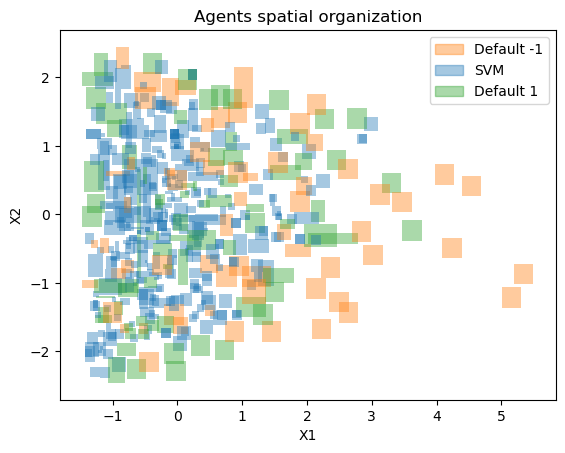

In [25]:
colors = {
    -1 : 'C1',
    0 : 'C0',
    1 : 'C2'
}

ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, re.estimator.agents.hypercubes.detach().numpy(), re.estimator.agents.base_prediction.numpy(),colors)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

custom_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[-1], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[0], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[1], alpha=0.4)]
custom_labels = ['Default -1', 'SVM', 'Default 1']

ax.legend(handles=custom_handles, labels=custom_labels)


### XGBoost

In [26]:
bst = XGBClassifier()
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.38      0.40       119
         1.0       0.50      0.55      0.52       132

    accuracy                           0.47       251
   macro avg       0.46      0.47      0.46       251
weighted avg       0.47      0.47      0.47       251

